<a href="https://colab.research.google.com/github/heheguoyang/NTHU_2025_DLBOI_HW4/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims
from torchvision import models

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [ ]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


In [ ]:
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device).long()  # ← 改成 long

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)  # ← 不再 unsqueeze(1)

        epoch_loss.append(loss.item())

        # Accuracy
        predicts = torch.argmax(preds, dim=1)  # ← 取最大機率類別
        acc = accuracy_score(labels.cpu().numpy(), predicts.cpu().numpy())
        epoch_acc.append(acc)

        loss.backward()
        optimizer.step()

    end_time = time.time()
    return np.mean(epoch_loss), np.mean(epoch_acc)*100, end_time - start_time


def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()
    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            preds = model(images)
            loss = criterion(preds, labels)

            epoch_loss.append(loss.item())
            predicts = torch.argmax(preds, dim=1)
            acc = accuracy_score(labels.cpu().numpy(), predicts.cpu().numpy())
            epoch_acc.append(acc)

    end_time = time.time()
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, end_time - start_time, best_acc


def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            preds = model(images)
            loss = criterion(preds, labels)
            test_loss.append(loss.item())

            predicts = torch.argmax(preds, dim=1)
            acc = accuracy_score(labels.cpu().numpy(), predicts.cpu().numpy())
            test_acc.append(acc)

    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100
    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc


# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/DLBOI_HW3/chest_xray/train'
test_path = '/content/drive/MyDrive/DLBOI_HW3/chest_xray/test'
val_path = '/content/drive/MyDrive/DLBOI_HW3/chest_xray/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Tried with 32, 128 as well
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)    # Tried with 32, 128 as well
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Tried with 32, 128 as well

print("DATA IS LOADING...")

DATA IS LOADING...


# Model

In [ ]:
# ResNet-50

# Task B start ===
# model = models.resnet50(weights='IMAGENET1K_V1')
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(model.fc.in_features, 2)
# model = model.to(device)
# Task B end ===

# Task C start ===
# model = models.resnet50(weights='IMAGENET1K_V1')
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# freeze layers
# for param in model.parameters():
#    param.requires_grad = False

# final layer
# model.fc = nn.Linear(model.fc.in_features, 2)

# for param in model.fc.parameters():
#    param.requires_grad = True
# Task C end ===

# =============================================================================================

# MobileNetV3
# Task B start ===
#model= models.mobilenet_v3_large(weights='IMAGENET1K_V1')
#first_conv = model.features[0][0]
#new_conv = nn.Conv2d(
#    in_channels=1,
#    out_channels=first_conv.out_channels,
#    kernel_size=first_conv.kernel_size,
#    stride=first_conv.stride,
#    padding=first_conv.padding,
#    bias=False
#)
#model.features[0][0] = new_conv
#model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
#model = model.to(device)
# Task B end ===

# Task C start ===
model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
first_conv = model.features[0][0]
new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=first_conv.out_channels,
    kernel_size=first_conv.kernel_size,
    stride=first_conv.stride,
    padding=first_conv.padding,
    bias=False
)
model.features[0][0] = new_conv

# freeze layers
for param in model.parameters():
    param.requires_grad = False

# final layer
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
for param in model.classifier[3].parameters():
    param.requires_grad = True

model = model.to(device)
# Task C end ===

model.to(device)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# Loop

In [ ]:
# hyperparameter
lr = 0.001 # Tried with 0.1, 0.01, 0.0001 as well
weight_decay = 0.001

# ResNet-50
# Task B start ===
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Task B end ===

# Task C start ===
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
# Task C end ===

# MobileNetV3
# Task B start ===
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Task B end ===

# Task C start ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[3].parameters(), lr=1e-4)
# Task C end ===

lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10 # Tried with 3, 10, 50 as well

# save checkpoint
save = 'model'

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/10 - loss: 0.6464 - train_acc: 64.75% - val_loss: 0.7401 - val_acc: 50.00% - time: 75.01s
Epoch 2/10 - loss: 0.5160 - train_acc: 85.30% - val_loss: 0.8288 - val_acc: 50.00% - time: 63.89s
Epoch 3/10 - loss: 0.4344 - train_acc: 88.09% - val_loss: 0.8287 - val_acc: 50.00% - time: 72.26s
Epoch 4/10 - loss: 0.3850 - train_acc: 89.84% - val_loss: 0.8351 - val_acc: 50.00% - time: 75.92s
Epoch 5/10 - loss: 0.3481 - train_acc: 90.09% - val_loss: 0.8406 - val_acc: 50.00% - time: 62.53s
Epoch 6/10 - loss: 0.3156 - train_acc: 90.77% - val_loss: 0.8488 - val_acc: 50.00% - time: 63.51s
Epoch 7/10 - loss: 0.2952 - train_acc: 90.92% - val_loss: 0.8554 - val_acc: 50.00% - time: 63.17s
Epoch 8/10 - loss: 0.2868 - train_acc: 91.02% - val_loss: 0.8265 - val_acc: 50.00% - time: 62.97s
Epoch 9/10 - loss: 0.2912 - train_acc: 91.02% - val_loss: 0.7968 - val_acc: 50.00% - time: 62.91s
Epoch 10/10 - loss: 0.2795 - train_acc: 91.06% - val_loss: 0.7526 - val_acc: 50.00% - time: 61.80s


# Graph

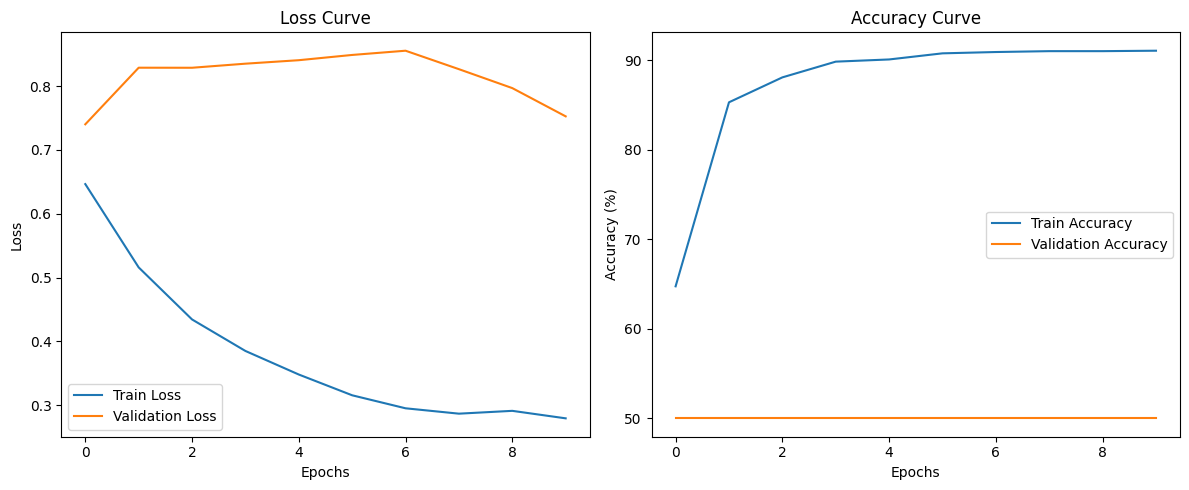

In [ ]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)

Model weights loaded successfully.
Test Accuracy: 63.44%
Test Loss: 0.6812
